# xgBoost Extreme Gradient Boosting

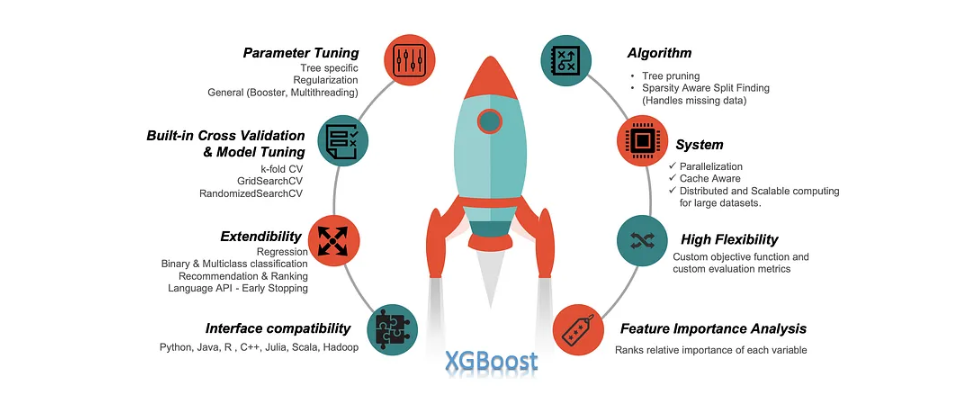

In [1]:

%pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Restart and run all cells

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

 ### Step 1 : Load the train data

In [3]:
import pandas as pd 
df = pd.read_csv("train_weather.csv")
df.head()


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


### Step 2: Perform basic data quality checks

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [6]:

df.duplicated().sum()

np.int64(0)

In [7]:
df['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

## Above is multiclass classification problem because it has more than 2 classes

### Step 3: X and Y (Weather Type)


In [8]:

X = df.drop(columns=['Weather Type'])
Y = df[['Weather Type']]

In [9]:
X.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain


In [10]:
Y.head()

,Weather Type
0,Rainy
1,Cloudy
2,Sunny
3,Sunny
4,Rainy


### Step 5: Apply preprocessing pipeline on X

In [11]:

X.dtypes

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
dtype: object

In [12]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [13]:
cat

['Cloud Cover', 'Season', 'Location']

In [14]:
con

['Temperature',
 'Humidity',
 'Wind Speed',
 'Precipitation (%)',
 'Atmospheric Pressure',
 'UV Index',
 'Visibility (km)']

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [16]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [17]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore',
                                                 sparse_output=False))])

In [18]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [19]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
0,-0.294931,0.212404,-0.048086,0.887629,0.134203,-0.520104,-0.582231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.143035,1.351385,-0.192836,0.543291,0.150602,0.776424,1.345768,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.625367,-0.233285,-0.409962,-1.178401,0.346579,0.257813,0.010999,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.085516,0.707613,-1.206089,0.887629,0.549008,0.776424,-1.323769,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.452811,0.261924,1.037543,0.386773,-0.407490,-0.779410,-0.878846,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### Beacuse i am working on xgboost, it requires target features to be label encoded

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_pre = le.fit_transform(Y)


In [21]:

Y_pre[0:5]

array([1, 0, 3, 3, 1])

In [22]:
Y.head()

,Weather Type
0,Rainy
1,Cloudy
2,Sunny
3,Sunny
4,Rainy


### Apply train test split on X_pre and Y_pre

In [43]:

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y_pre, 
                                                test_size=0.2,
                                                random_state=42)

In [24]:

xtrain.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
3958,0.740404,-0.134243,-0.554712,1.200664,0.117804,-0.520104,-1.175461,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2239,-0.237413,1.351385,0.169040,0.105042,0.299802,-1.038715,-0.433923,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3608,0.510330,-0.530410,-0.482337,-1.334918,0.525351,1.554340,1.049153,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6848,1.603184,0.757134,5.018179,0.981540,-0.364746,-0.520104,-1.027154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6119,-0.064857,-0.134243,0.603291,-1.366221,-0.155596,-0.779410,0.752538,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:

ytrain[0:5]

array([1, 1, 3, 1, 0])

In [26]:
xtest.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
4111,0.222737,-1.520829,-0.771838,-1.491435,0.412980,1.295035,1.345768,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
10607,2.465964,1.252343,0.675666,0.918933,0.530728,1.554340,-0.433923,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7372,1.200553,-0.877057,-1.133714,-1.303614,0.519437,1.035729,0.752538,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11786,-1.502823,0.509529,-0.482337,1.138057,-0.329798,-1.038715,-1.175461,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12227,0.107699,1.252343,0.024290,1.732823,0.588257,1.813646,1.049153,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [27]:
ytest[0:5]


array([3, 3, 3, 2, 3])

In [28]:
xtrain.shape

(10560, 18)

In [29]:
xtest.shape

(2640, 18)

### Step 6: Model Building

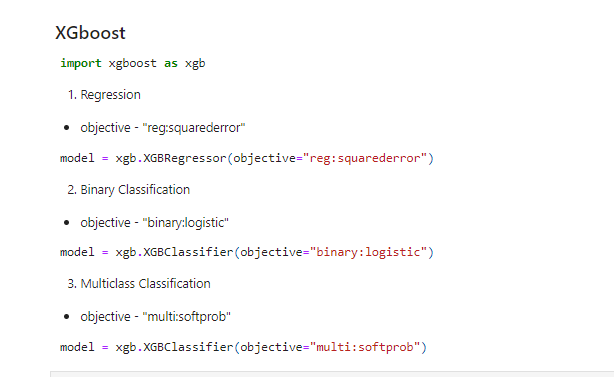

In [33]:
import xgboost as xgb

In [34]:

model = xgb.XGBClassifier(objective="multi:softprob",
                          n_estimators=300,
                          max_depth=3,
                          random_state=42)
model.fit(xtrain, ytrain, 
          eval_set=[(xtrain, ytrain), (xtest, ytest)], 
          verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Step 7 : Model Evaluation


In [35]:
model.score(xtrain, ytrain)

0.9961174242424242

In [36]:
model.score(xtest, ytest)

0.9128787878787878

In [37]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring='f1_macro')

In [38]:
scores

array([0.91911932, 0.9086168 , 0.90742918, 0.91393434, 0.92101424])

In [39]:
scores.mean()

np.float64(0.9140227744821485)

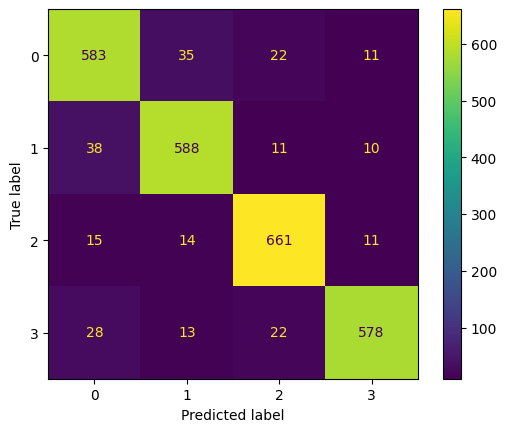

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, xtest, ytest)

### Predict for train and test

In [41]:
ypred_train = model.predict(xtrain)
ypred_test = model.predict(xtest)

In [42]:
ypred_test[0:5]

array([3, 3, 3, 2, 3])

In [44]:
ytest[0:5]

array([3, 3, 3, 2, 3])

In [45]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       651
           1       0.90      0.91      0.91       647
           2       0.92      0.94      0.93       701
           3       0.95      0.90      0.92       641

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



In [46]:
le

LabelEncoder()

In [47]:
ypred_train_lab = le.inverse_transform(ypred_train)
ypred_test_lab = le.inverse_transform(ypred_test)

In [48]:
ypred_test_lab[0:5]

array(['Sunny', 'Sunny', 'Sunny', 'Snowy', 'Sunny'], dtype=object)

In [49]:
ypred_train_lab[0:5]

array(['Rainy', 'Rainy', 'Sunny', 'Rainy', 'Cloudy'], dtype=object)

### Step 9: Out of sample prediction

In [50]:
xnew = pd.read_csv("test_weather.csv")

In [51]:

xnew.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland


In [52]:

xnew.shape

(100, 10)

In [53]:

pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Temperature', 'Humidity', 'Wind Speed',
                                  'Precipitation (%)', 'Atmospheric Pressure',
                                  'UV Index', 'Visibility (km)']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Cloud Cover', 'Season', 'Location'])])

In [54]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
0,-1.100192,-0.035201,0.892792,0.386773,-0.561530,-1.038715,-1.027154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,5.054302,1.896115,0.748042,0.918933,0.246574,1.813646,0.455922,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.007338,0.360966,0.386166,-0.583634,0.307330,-0.001493,0.752538,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.165218,1.499948,1.254668,0.136346,0.184743,-1.038715,-0.582231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.797923,-2.164601,-0.265211,-1.491435,0.482338,0.517118,-0.137308,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [55]:
preds = model.predict(xnew_pre)
preds

array([2, 3, 0, 1, 3, 0, 2, 2, 2, 3, 1, 1, 2, 0, 3, 2, 0, 1, 1, 2, 1, 1,
       0, 1, 3, 2, 0, 0, 1, 2, 3, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 1, 2, 2,
       0, 1, 2, 0, 2, 3, 3, 0, 1, 1, 3, 1, 3, 0, 1, 1, 3, 2, 3, 0, 2, 3,
       2, 0, 1, 2, 1, 1, 1, 0, 0, 3, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 3, 0,
       0, 2, 3, 3, 2, 2, 3, 0, 1, 2, 3, 0])

In [56]:
preds_lab = le.inverse_transform(preds)
preds_lab

array(['Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Sunny', 'Cloudy', 'Snowy',
       'Snowy', 'Snowy', 'Sunny', 'Rainy', 'Rainy', 'Snowy', 'Cloudy',
       'Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Rainy', 'Snowy', 'Rainy',
       'Rainy', 'Cloudy', 'Rainy', 'Sunny', 'Snowy', 'Cloudy', 'Cloudy',
       'Rainy', 'Snowy', 'Sunny', 'Cloudy', 'Snowy', 'Rainy', 'Rainy',
       'Cloudy', 'Cloudy', 'Cloudy', 'Rainy', 'Cloudy', 'Snowy', 'Rainy',
       'Snowy', 'Snowy', 'Cloudy', 'Rainy', 'Snowy', 'Cloudy', 'Snowy',
       'Sunny', 'Sunny', 'Cloudy', 'Rainy', 'Rainy', 'Sunny', 'Rainy',
       'Sunny', 'Cloudy', 'Rainy', 'Rainy', 'Sunny', 'Snowy', 'Sunny',
       'Cloudy', 'Snowy', 'Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Snowy',
       'Rainy', 'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Sunny', 'Rainy',
       'Rainy', 'Rainy', 'Cloudy', 'Snowy', 'Snowy', 'Rainy', 'Rainy',
       'Snowy', 'Snowy', 'Sunny', 'Cloudy', 'Cloudy', 'Snowy', 'Sunny',
       'Sunny', 'Snowy', 'Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Snow

In [57]:
model.classes_

array([0, 1, 2, 3])

In [58]:
probs = model.predict_proba(xnew_pre)
probs[0:5]

array([[6.9930429e-06, 3.2922300e-05, 9.9994397e-01, 1.6076094e-05],
       [1.8633101e-02, 4.4759587e-04, 1.1654436e-05, 9.8090762e-01],
       [9.9058199e-01, 2.4051499e-03, 4.9871783e-04, 6.5140948e-03],
       [2.0203758e-03, 9.9661523e-01, 3.2511944e-04, 1.0392354e-03],
       [1.7833960e-05, 1.8272566e-04, 6.4569205e-04, 9.9915373e-01]],
      dtype=float32)

In [59]:
import numpy as np 
max_probs = np.max(probs, axis=1)
max_probs

array([0.999944  , 0.9809076 , 0.990582  , 0.99661523, 0.99915373,
       0.9899607 , 0.99987495, 0.99959964, 0.9993765 , 0.96923   ,
       0.9677104 , 0.9993438 , 0.9990403 , 0.99660563, 0.99990094,
       0.9979633 , 0.9961628 , 0.66781104, 0.7061758 , 0.9999385 ,
       0.98833406, 0.9975435 , 0.99833626, 0.9983443 , 0.6823338 ,
       0.9994337 , 0.9964921 , 0.8927991 , 0.98793787, 0.9993581 ,
       0.99998224, 0.9949398 , 0.9998086 , 0.46396106, 0.99023825,
       0.992278  , 0.9159442 , 0.9925552 , 0.9975733 , 0.5734335 ,
       0.9984749 , 0.98289776, 0.99516463, 0.99988973, 0.9954904 ,
       0.9993789 , 0.9998573 , 0.9927154 , 0.9982504 , 0.9999951 ,
       0.9999987 , 0.95252156, 0.9994307 , 0.99942565, 0.99997795,
       0.85712767, 0.99961084, 0.4344765 , 0.99886835, 0.9896937 ,
       0.99994755, 0.9996588 , 0.9999938 , 0.7722879 , 0.99991393,
       0.99993765, 0.99904174, 0.65121216, 0.9938021 , 0.99936575,
       0.9974565 , 0.9984586 , 0.6145495 , 0.99310654, 0.99891

In [60]:
xnew['Weather_type_pred'] = preds_lab
xnew['prob'] = max_probs

In [61]:
xnew

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather_type_pred,prob
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain,Snowy,0.999944
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain,Sunny,0.980908
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland,Cloudy,0.990582
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland,Rainy,0.996615
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland,Sunny,0.999154
...,...,...,...,...,...,...,...,...,...,...,...,...
95,27,59,9.5,41.0,overcast,1001.39,4,Spring,8.0,mountain,Cloudy,0.999464
96,73,82,47.0,107.0,overcast,1002.73,0,Winter,0.5,mountain,Rainy,0.999730
97,2,60,3.0,70.0,overcast,994.19,0,Winter,2.0,mountain,Snowy,0.999776
98,33,44,1.5,11.0,clear,1011.95,7,Summer,8.5,inland,Sunny,0.999957


In [62]:

xnew.to_csv("xgbResults.csv", index=False)

### Get the feature importances

In [63]:
model.feature_importances_

array([0.08042917, 0.00592751, 0.0063642 , 0.0395065 , 0.0220015 ,
       0.07620671, 0.03669349, 0.6053045 , 0.01309693, 0.02138668,
       0.00768963, 0.00563845, 0.0039    , 0.00299883, 0.05730655,
       0.00820474, 0.00275087, 0.00459381], dtype=float32)

In [64]:
xtrain.columns

Index(['num__Temperature', 'num__Humidity', 'num__Wind Speed',
       'num__Precipitation (%)', 'num__Atmospheric Pressure', 'num__UV Index',
       'num__Visibility (km)', 'cat__Cloud Cover_clear',
       'cat__Cloud Cover_cloudy', 'cat__Cloud Cover_overcast',
       'cat__Cloud Cover_partly cloudy', 'cat__Season_Autumn',
       'cat__Season_Spring', 'cat__Season_Summer', 'cat__Season_Winter',
       'cat__Location_coastal', 'cat__Location_inland',
       'cat__Location_mountain'],
      dtype='object')

In [65]:
imp = pd.Series(model.feature_importances_, index=xtrain.columns)
imp

num__Temperature                  0.080429
num__Humidity                     0.005928
num__Wind Speed                   0.006364
num__Precipitation (%)            0.039506
num__Atmospheric Pressure         0.022001
num__UV Index                     0.076207
num__Visibility (km)              0.036693
cat__Cloud Cover_clear            0.605304
cat__Cloud Cover_cloudy           0.013097
cat__Cloud Cover_overcast         0.021387
cat__Cloud Cover_partly cloudy    0.007690
cat__Season_Autumn                0.005638
cat__Season_Spring                0.003900
cat__Season_Summer                0.002999
cat__Season_Winter                0.057307
cat__Location_coastal             0.008205
cat__Location_inland              0.002751
cat__Location_mountain            0.004594
dtype: float32

<Axes: >

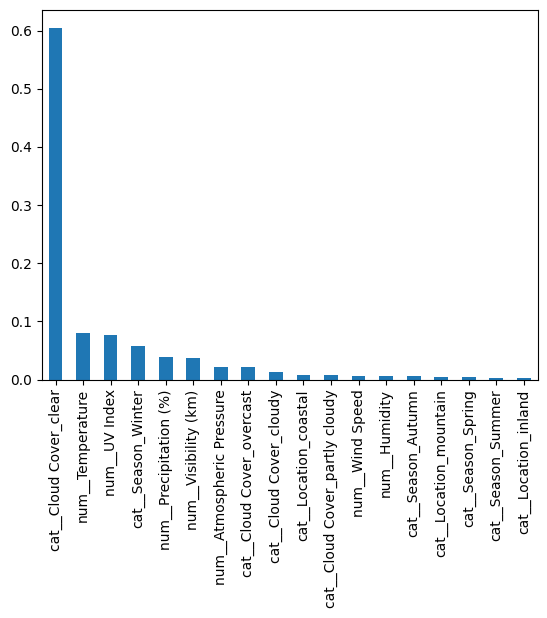

In [66]:
imp.sort_values(ascending=False).plot(kind='bar')